In [1]:
from dateutil.relativedelta import relativedelta
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def dayFraction(t,T,dayCountConvention):
    """Get the day fraction T-t following a day count convention
    
    Parameters
    ----------
    
    t: str
        the starting date under the format `yyyy-mm-dd`
        
    T: str
        the ending date under the format `yyyy-mm-dd`
        
    dayCountConvention: str
        `ACT/365` or `ACT/360` or `30/360`
        
    Return
    ------
    double
        the year fraction
    """
    try:
        start_date = date.fromisoformat(t)
        end_date = date.fromisoformat(T)
    except:
        print("Enter the right format of the dates.")
    if (dayCountConvention == 'ACT/365'):
        # compute the number of days    
        numberOfDays = (end_date - start_date).days
        yearFraction = numberOfDays / 365
        return yearFraction
    elif(dayCountConvention == 'ACT/360'):
        # compute the number of days    
        numberOfDays = (end_date - start_date).days
        yearFraction = numberOfDays / 360
        return yearFraction
    elif(dayCountConvention == '30/360'):
        yearFraction = (
            (min(end_date.day,30) + max(30-start_date.day,0))/360 
            + (end_date.month - start_date.month - 1)/12 
            + (end_date.year - start_date.year)
        )
        return yearFraction
    else:
        return("Consult the documentation of the function")

---

In [3]:
def zero_coupon_bond(t, T, dayCountConvention, composition, rate):
    """Get the  price of the T-Bond P(t,T)
    
    Parameters
    ----------
    t: str
        the starting date under the format `yyyy-mm-dd`
        
    T: str
        the ending date under the format `yyyy-mm-dd`
    composition: str
        `sc`: simple compounding
        `cc`: continuous compounding
    rate: double
        By default the term-structure of interest rates is `flat`.
        We assume that the rates are same.
    dayCountConvention: str
        `ACT/365` or `ACT/360` or `30/360`
    
    Return
    ------
    double
        The price
        
    """
    P = 0.0
    if(composition == "sc"):
        P = (1 / (1 + (dayFraction(t,T,dayCountConvention)*rate)))
    elif(composition == "cc"):
        P = np.exp(-(dayFraction(t,T,dayCountConvention)*rate))
    return P

---

In [4]:
def CouponBondPrice(N, cp, cp_freq, settlement, mat, dayCountConvention, composition, rate, valuation):
    """Get the price of a coupon-bearing bond
    
    Parameters
    ----------
    N: double
        the Notional of the bond
        
    cp: double
        the coupon rate in year unit
    
    cp_freq: str
        `semi-annual` or `annual`. The frequency at which coupons are paid.
        
    settlement: str
        Initial date under the format `yyyy-mm-dd` from which we have a calendar of cashflows.
        
    mat: int
        The time to the maturity of the bond expressed in years.
    
    dayCountConvention: str
        `ACT/365` or `ACT/360` or `30/360`
        
    composition: str
        `sc`: simple compounding
        `cc`: continuous compounding
    
    rate: double
        By default the term-structure of interest rates is `flat`.
        We assume that the rates are same.
        
    valuation: str
        The date of valuation under the format `yyyy-mm-dd` if it's string.
    
    Return
    ------
    double
        The price of the bond.
    """
    # Initialisation
    ech = []
    settlement_date = date.fromisoformat(settlement)
    final_date = settlement_date + relativedelta(years=mat)
    
    if(cp_freq == "semi-annual"):
        while(settlement_date < final_date):
            settlement_date += relativedelta(months=6)
            ech.append(settlement_date)
        # Get the first date in `ech` greater than `val_date`
        val_date = date.fromisoformat(valuation)
        tmp_min = min(elt for elt in ech if elt > val_date)
        # Get the index of tmp_min in `ech`
        idx = ech.index(tmp_min)
        # Get the set of date `T` to compute the discount factor
        setOfT = ech[idx:]
        setOfT = [T.strftime("%Y-%m-%d") for T in setOfT]
        # Period of the coupon [Ti-1, Ti]
            # Constant frequency => deal with the year fraction of the period [T0,T1]
        YearFractionCoupon = dayFraction(ech[0].strftime("%Y-%m-%d"), ech[1].strftime("%Y-%m-%d"), dayCountConvention)
        # Bon_price
        prices = [
            YearFractionCoupon*cp*N*zero_coupon_bond(valuation,T, dayCountConvention,composition,rate) for T in setOfT
        ]
        bon_price = sum(prices) + N*zero_coupon_bond(valuation,setOfT[-1], dayCountConvention,composition,rate)
        
    elif(cp_freq == "annual"):
        while(settlement_date < final_date):
            settlement_date += relativedelta(years=1)
            ech.append(settlement_date)
        # Get the first date in `ech` greater than `val_date`
        val_date = date.fromisoformat(valuation)
        try:
            tmp_min = min(elt for elt in ech if elt>val_date)
        except:
            print("Maturity must be greater than 0")
        # Get the index of tmp_min in `ech`
        idx = ech.index(tmp_min)
        # Get the set of date `T` to compute the discount factor
        setOfT = ech[idx:]
        setOfT = [T.strftime("%Y-%m-%d") for T in setOfT]
        # Bon_price
        prices = [cp*N*zero_coupon_bond(valuation,T, dayCountConvention,composition,rate) for T in setOfT]
        bon_price = sum(prices) + N*zero_coupon_bond(valuation,setOfT[-1], dayCountConvention,composition,rate)
        
    return {"Price": bon_price, "settlement date": settlement, "calendar of coupon payments":setOfT}

In [5]:
#test
CouponBondPrice(100,0.1,"semi-annual","2023-07-31",2,"30/360","cc",0.05,"2023-07-31")

{'Price': 109.27934300806373,
 'settlement date': '2023-07-31',
 'calendar of coupon payments': ['2024-01-31',
  '2024-07-31',
  '2025-01-31',
  '2025-07-31']}

In [6]:
def fig_curve_price(N, cp, cp_freq, settlement, mat, dayCountConvention, composition, rate, valuation):
    """
    """
    settlement_date = date.fromisoformat(settlement)
    final_date = settlement_date + relativedelta(years=mat)
    # Number of days between the settlement and the final date
    numberOfDays = (final_date - settlement_date).days
    
    # x-Axis
    times = [settlement_date + relativedelta(days=i) for i in range(numberOfDays)]
    times = [T.strftime("%Y-%m-%d") for T in times]
    
    # y-Axis
    Prices = [
        CouponBondPrice(N, cp, cp_freq, settlement, mat, dayCountConvention, composition, rate, t)["Price"] for t in times
    ]
    # At Tn, the price is the notional
    Prices.append(N)
    times.append(final_date.strftime("%Y-%m-%d"))
    
    
    #--------------------------------------------------------------------------------------------------------------------
    # Plot
    bond_price = CouponBondPrice(N, cp, cp_freq, settlement, mat, dayCountConvention, composition, rate, valuation)["Price"]
    labels = CouponBondPrice(N, cp, cp_freq, settlement, mat, dayCountConvention, composition, rate, settlement)["calendar of coupon payments"]
    
    fig = plt.plot(times, Prices)
    plt.xlabel("Dates of Coupon payments")
    ax = plt.gca()
    ax.set_xticks(labels)
    ax.set_xticklabels(labels, rotation=90)
    
    plt.ylabel("Bond Price")
    plt.title(f"{mat}-Years Bond, Notional: {N} \n Evolution of prices from {settlement} to {times[-1]}")
    # show
    textstr = f"Coupon rate: {round(cp*100,2)}%\n Frequency: {cp_freq}\n Composition: {composition}\n Flat Yield Curve: {round(rate*100,2)}%\n Price on {valuation}: {round(bond_price,3)}"
    plt.text(
        0.95,
        0.85,
        textstr,
        ha="right",
        va="center",
        fontsize=10,
        bbox={"facecolor": "orange", "alpha": 0.5},
         transform=ax.transAxes
    )
    plt.show()

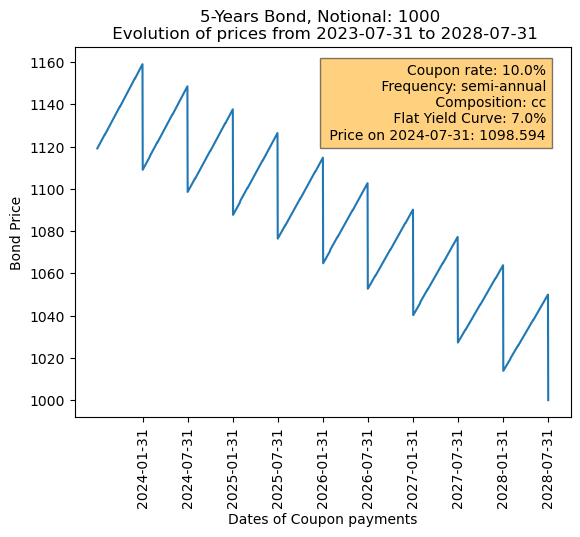

In [7]:
fig_curve_price(1000,0.1,"semi-annual","2023-07-31",5,"30/360","cc",0.07,"2024-07-31")